### Task 1

In [1]:
# Import Required Libraries
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Set random seed for reproducibility (same results every run)
np.random.seed(42)

In [2]:
# Implement the Gillespie SSA
def gillespie_ssa(k1, k2, E0, S0, C0, P0, max_time):
    """
    Run Gillespie SSA for the enzymatic reaction system.
    
    Returns:
        sim_times (np.array): Time points recorded during the simulation.
        sim_S (np.array): Corresponding substrate counts (S) at each time point.
    """
    # Initialize time and state variables
    t = 0.0
    E, S, C, P = E0, S0, C0, P0
    
    # Store time points and S values (we only need S for analysis)
    sim_times = [t]
    sim_S = [S]
    
    # Main SSA loop (run until max_time or no more reactions)
    while t < max_time:
        # 1. Calculate propensities for each reaction
        a1 = k1 * E * S  # Propensity for E + S → C
        a2 = k2 * C      # Propensity for C → E + P
        a0 = a1 + a2     # Total propensity (sum of all reaction likelihoods)
        
        # If no more reactions can occur (a0=0), exit early
        if a0 == 0:
            break
        
        # 2. Sample time to next reaction (tau)
        r1 = np.random.rand()  # Uniform random number [0,1)
        tau = (1 / a0) * np.log(1 / r1)  # Time until next reaction
        
        # 3. Sample which reaction occurs
        r2 = np.random.rand()  # Another uniform random number [0,1)
        if r2 < a1 / a0:
            # Reaction 1: E + S → C (update state)
            E -= 1
            S -= 1
            C += 1
        else:
            # Reaction 2: C → E + P (update state)
            C -= 1
            E += 1
            P += 1
        
        # 4. Update time and record new state
        t += tau
        sim_times.append(t)
        sim_S.append(S)
    
    # Convert to numpy arrays for easier manipulation
    return np.array(sim_times), np.array(sim_S)

### Task 2 & 3

In [3]:
# Simulation with the following parameters and initial conditions
k1 = 0.001  # Rate for E + S → C
k2 = 0.5    # Rate for C → E + P

# Initial molecule counts (E, S, C, P)
E0 = 100
S0 = 1000
C0 = 0
P0 = 0

# Simulation settings (500 simulations with t_max = 20)
max_time = 20          # Run until t=20
n_simulations = 500    # Number of stochastic trajectories

In [4]:
# Store results of all simulations (each entry = (time_points, S_values))
ensemble = []

print(f"Running {n_simulations} stochastic simulations...")
for i in range(n_simulations):
    # Run SSA for one simulation
    sim_times, sim_S = gillespie_ssa(k1, k2, E0, S0, C0, P0, max_time)
    ensemble.append((sim_times, sim_S))
print("All simulations completed!")

Running 500 stochastic simulations...
All simulations completed!


### Task 4 & 5 & 6

In [5]:
# Create a smooth common time grid (0 to max_time, 200 points)
common_times = np.linspace(0, max_time, num=200)

# Interpolate each simulation's S(t) onto the common grid
# Shape: (n_simulations, len(common_times))
interpolated_S = np.zeros((n_simulations, len(common_times)))

for i, (sim_times, sim_S) in enumerate(ensemble):
    # Linear interpolation; fill times beyond simulation end with final S value
    interpolator = interp1d(
        sim_times, sim_S,
        kind="linear",       # Linear interpolation between points
        bounds_error=False,  # No error for times outside sim_times
        fill_value=sim_S[-1] # Use final S value for times beyond sim end
    )
    # Interpolate to common time grid
    interpolated_S[i, :] = interpolator(common_times)

# Compute the mean S(t) across all 500 simulations
mean_stochastic_S = np.mean(interpolated_S, axis=0)

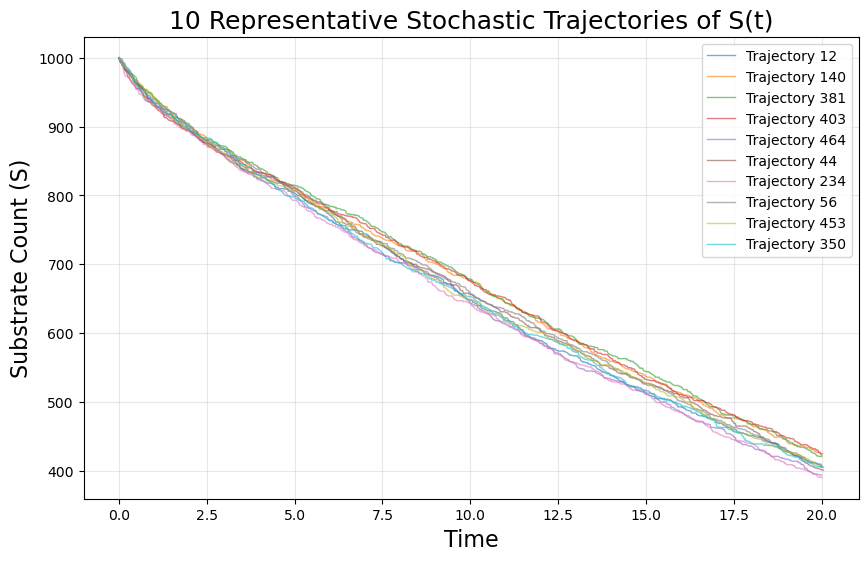

In [10]:
plt.figure(figsize=(10, 6))

# Pick 10 random trajectories from the ensemble (reproducible via seed=42)
representative_indices = np.random.choice(n_simulations, size=10, replace=False)
for idx in representative_indices:
    sim_times, sim_S = ensemble[idx]
    plt.plot(sim_times, sim_S, alpha=0.6, linewidth=1, label=f"Trajectory {idx+1}")

plt.xlabel("Time", fontsize=16)
plt.ylabel("Substrate Count (S)", fontsize=16)
plt.title("10 Representative Stochastic Trajectories of S(t)", fontsize=18)
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

#### Derive and solve the Deterministic ODEs

In [7]:
def enzymatic_odes(t, y, k1, k2):
    """ODE function for the enzymatic reaction system."""
    E, S, C, P = y  # y = [E, S, C, P]
    dE_dt = -k1 * E * S + k2 * C
    dS_dt = -k1 * E * S
    dC_dt = k1 * E * S - k2 * C
    dP_dt = k2 * C
    return [dE_dt, dS_dt, dC_dt, dP_dt]

# Initial condition for ODEs (same as SSA)
y0 = [E0, S0, C0, P0]

# Solve ODEs (get solution at common_times for easy comparison)
ode_solution = solve_ivp(
    fun=lambda t, y: enzymatic_odes(t, y, k1, k2),  # ODE function
    t_span=[0, max_time],                            # Time range
    y0=y0,                                           # Initial condition
    t_eval=common_times,                             # Evaluate at common time grid
    method="RK45"                                    # Robust ODE solver
)

# Extract deterministic S(t) (y[1] corresponds to S in the ODE state)
deterministic_S = ode_solution.y[1, :]

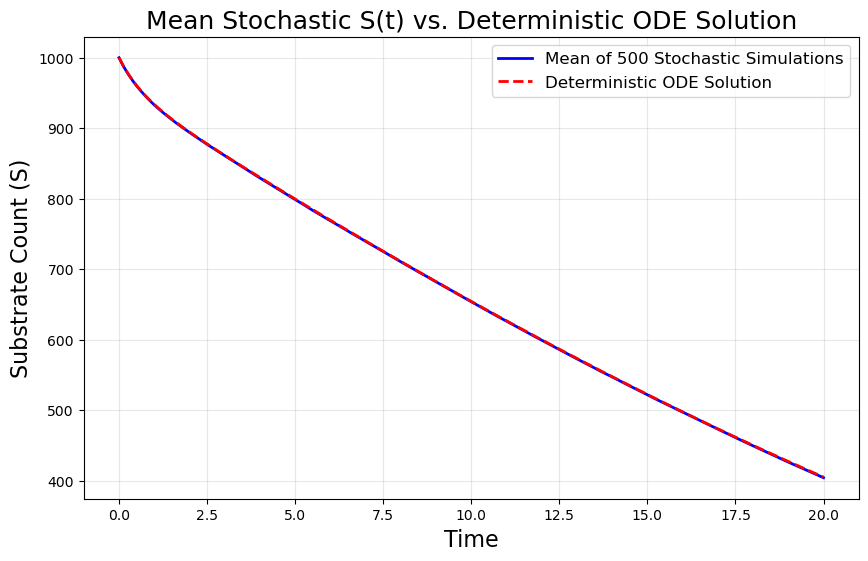

In [11]:
plt.figure(figsize=(10, 6))

# Plot mean of stochastic simulations
plt.plot(
    common_times, mean_stochastic_S,
    label="Mean of 500 Stochastic Simulations",
    color="blue", linewidth=2
)

# Plot deterministic ODE solution
plt.plot(
    common_times, deterministic_S,
    label="Deterministic ODE Solution",
    color="red", linestyle="--", linewidth=2
)

plt.xlabel("Time", fontsize=16)
plt.ylabel("Substrate Count (S)", fontsize=16)
plt.title("Mean Stochastic S(t) vs. Deterministic ODE Solution", fontsize=18)
plt.legend(loc="best", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Task 7

## Relationship Between Stochastic Mean and Deterministic Solution

The mean of the 500 stochastic simulations (blue line) shows **excellent agreement** with the deterministic ODE solution (red dashed line). This consistency is expected due to two key reasons:

1. **Law of Large Numbers**: As the number of stochastic simulations increases, the random "noise" (fluctuations from individual molecular collisions) cancels out. The average behavior of the discrete, random trajectories converges to the smooth, deterministic prediction of the ODEs.

2. **Large Initial Counts**: The system has large initial counts of substrate (S₀=1000) and enzyme (E₀=100). For systems with many molecules, the relative size of stochastic fluctuations (compared to the mean) is small, so the mean trajectory closely matches the deterministic expectation.

Minor discrepancies may appear at early times (where fluctuations are relatively larger), but with 500 simulations, these are negligible. This confirms that the ODE model correctly captures the **expected behavior** of the enzymatic reaction, while the SSA captures the full stochastic variability.